In [1]:
import aesmc.train as train
import aesmc.losses as losses
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from arm_models import DTC_2D_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # video plotting + params to coords
from aesmc import statistics # to simulate from prior and summarize post.

In [2]:
# define global params which we're not inferring 
# ToDo: onsider having consts dict
g= 0.2
dt=0.03
transition_scale = 0.3
emission_scale = 0.1
proposal_scale_0 = 0.1
proposal_scale_t = 0.05
initial_loc = torch.zeros(2)
initial_scale = 1 # * torch.eye(2)
# define true params (to simualte data from)
true_transition_mult = 1
true_emission_mult = 1
# if learning distributions:
init_transition_mult = 0
init_emission_mult = 0
# define train/infer params
num_timesteps = 100
num_test_obs = 10
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 100

In [3]:
# set up true values. later, we'll initialize from a different point and see how well
# we're doing.
inits_dict_true = {}
inits_dict_true["L1"] = 1.25
inits_dict_true["L2"] = 0.75
inits_dict_true["M1"] = 0.5
inits_dict_true["M2"] = 0.35 
# init values for intermediate variables in the emission model
inits_dict_true["velocity_vec"] = torch.zeros([batch_size*num_particles, 2])
inits_dict_true["angle_vec"] = torch.zeros([batch_size*num_particles, 2])

### Define true distributions
To simulate data from the true model.

In [4]:
initial = DTC_2D_model.Initial(initial_loc, initial_scale)
transition = DTC_2D_model.Transition(true_transition_mult, transition_scale)
emission = DTC_2D_model.Emission(inits_dict_true, dt, g, emission_scale, False)

Define bootsrap proposal. It will serve us later for inference.

In [5]:
proposal = DTC_2D_model.Bootstrap_Proposal(initial_scale, initial_loc, 
                                             transition_scale, true_transition_mult)

In [6]:
# # ToDo: decide whether or not it's relevant here
# # set up data loader for simulated data from true distribution
# dataloader = train.get_synthetic_dataloader(
#             initial,
#             transition,
#             emission,
#             num_timesteps, batch_size)

my understanding - `statistics.sample_from_prior` instructs the objects to sample one particle no matter what is my num particles. now, when i'm giving an initial value that has `torch.Size[batch_size, num_particles, 2]` for the angles, with `num_particles` different from zero, this messes things up. Every intermediate quantity in the emmision should be aligned with the desired number of particles.

In [7]:
# use statistics.sample_from_prior to obtain simulated latens and observations
# now we're setting it to be a "one particle sample". it seems to work.
# but we'll have to reset number of particles to 100. ToDo: fix, generalize
# num_particles = 1
# inits_dict_true["velocity_vec"] = torch.zeros([batch_size*num_particles, 2])
# inits_dict_true["angle_vec"] = torch.zeros([batch_size*num_particles, 2])
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

itreration 0: length of latent[-1] =  1
itreration 0: shape of latents[-1] =  torch.Size([10, 1, 2])
itreration i: length of latent[-1] =  2
itreration i: shape of latents[-1] =  torch.Size([10, 1, 2])
regular latents:  torch.Size([10, 1, 2])
contig latents:  torch.Size([10, 1, 2])
True
itreration i: length of latent[-1] =  3
itreration i: shape of latents[-1] =  torch.Size([10, 1, 2])
regular latents:  torch.Size([10, 1, 2])
contig latents:  torch.Size([10, 1, 2])
True
itreration i: length of latent[-1] =  4
itreration i: shape of latents[-1] =  torch.Size([10, 1, 2])
regular latents:  torch.Size([10, 1, 2])
contig latents:  torch.Size([10, 1, 2])
True
itreration i: length of latent[-1] =  5
itreration i: shape of latents[-1] =  torch.Size([10, 1, 2])
regular latents:  torch.Size([10, 1, 2])
contig latents:  torch.Size([10, 1, 2])
True
itreration i: length of latent[-1] =  6
itreration i: shape of latents[-1] =  torch.Size([10, 1, 2])
regular latents:  torch.Size([10, 1, 2])
contig la

In [8]:
len(emission.angles)
emission.angles[-1].shape
len(emission.angles)
len(emission.acceleration) # one timestep less than others.

100

In [9]:
# save ground truth variables
true_angles_list = emission.angles
true_velocity_list = emission.velocity
true_acceleration_list = emission.acceleration

In [10]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
lat_data.shape # [batch_size, dim_latents, num_timesteps]

torch.Size([10, 2, 100])

In [11]:
from aesmc import inference

inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=1000
        )

itreration 0: length of latent[-1] =  1
itreration 0: shape of latents[-1] =  torch.Size([10, 1000, 2])
itreration i: length of latent[-1] =  2
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  3
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  4
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  5
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  6
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular 

itreration i: length of latent[-1] =  48
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  49
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  50
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True
itreration i: length of latent[-1] =  51
itreration i: shape of latents[-1] =  torch.Size([10, 1000, 2])
regular latents:  torch.Size([10, 1000, 2])
contig latents:  torch.Size([10, 1000, 2])
True


ValueError: The value argument must be within the support

In [13]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

NameError: name 'inference_result' is not defined

In [29]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2) # now b, should be obs in observations
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [30]:
smooth_mean.shape

torch.Size([10, 2, 100])

In [31]:
ind_in_batch = 4
dim_lat_plot = 0
np.max(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy()) # 0! it's also not on the same scale

0.09610748

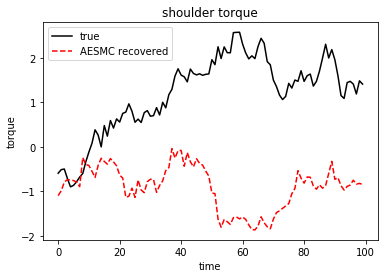

In [33]:
ind_in_batch = 2 # could be between 0 and batch_size-1
dim_lat_plot = 1
plt.plot(lat_data[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'black', label="true");
plt.plot(smooth_mean[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'red', 
         linestyle = 'dashed', label = "AESMC recovered");
#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
plt.title('shoulder torque')
plt.ylabel('torque')
plt.xlabel('time')
plt.legend();
#plt.savefig('first_fig_aesmc.png')

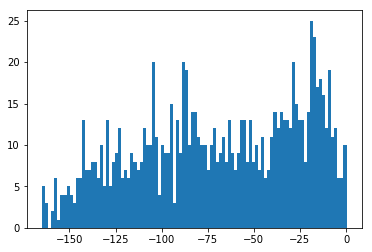

In [34]:
plt.hist(inference_result["log_weight"][0,:].detach().numpy(), bins=100);

In [20]:
emission.angles[-1].shape

torch.Size([10000, 2])

In [52]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_angle_means = []
smc_smoothed_angle_variances = []
for angle in emission.angles:
    smc_smoothed_angle_means.append(statistics.empirical_mean(
        angle.view(batch_size, 1000, 2), inference_result['log_weight']
    ))
    smc_smoothed_angle_variances.append(statistics.empirical_variance(
        angle.view(batch_size, 1000, 2), inference_result['log_weight']
    ))

In [53]:
smooth_mean_angle =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_angle_means], dim=2)
smooth_var_angle = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_angle_variances], dim=2)

In [54]:
ind_in_batch = 8 # could be between 0 and batch_size-1
x_hat , y_hat = arm_utils.coords_from_params_mat(smooth_mean_angle[ind_in_batch,0,:].detach().numpy(), 
                                       smooth_mean_angle[ind_in_batch,1,:].detach().numpy(), 
                                                 inits_dict_true["L1"], inits_dict_true["L2"])

In [55]:
x_obs = sim_data[ind_in_batch, [0,2,4], :].detach().numpy().T
y_obs = sim_data[ind_in_batch, [1,3,5], :].detach().numpy().T

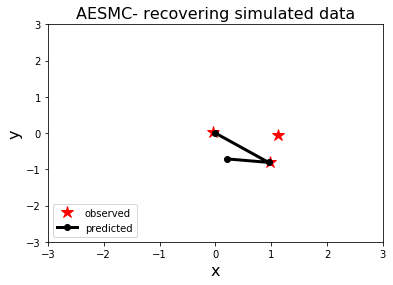

In [56]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             'DTC-2D_plots/dtc-2d-recovered', 
                   "AESMC- recovering simulated data", 
                             x_hat.shape[0], inits_dict_true["L1"] + 
                             inits_dict_true["L2"] + 1)

In [84]:
emission(latents=a, time=0)

RuntimeError: shape '[10, 100, 2]' is invalid for input of size 20

In [86]:
emission.angles[-1].shape

torch.Size([10, 2])